In [47]:
import numpy as np
import pandas as pd
import os

In [48]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [9]:
from zipfile import ZipFile

file_name = "./dataset/stage1_train.zip"
  
with ZipFile(file_name, 'r') as zip: 
    print('Extracting all the files now...') 
    zip.extractall("stage1_train") 
    print('Done!')

Extracting all the files now...
Done!


In [10]:
file_name = "./dataset/stage1_test.zip"

with ZipFile(file_name, 'r') as zip: 
    print('Extracting all the files now...') 
    zip.extractall("stage1_test") 
    print('Done!')

Extracting all the files now...
Done!


In [38]:
TRAIN_PATH="stage1_train/"
TEST_PATH='stage1_test/'

In [39]:
train_ids=next(os.walk(TRAIN_PATH))[1]
test_ids=next(os.walk(TEST_PATH))[1]
print(len(train_ids))

670


In [40]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

In [50]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing training images and masks


100%|██████████| 670/670 [02:29<00:00,  4.49it/s]


Resizing test images


100%|██████████| 65/65 [00:00<00:00, 76.04it/s]

Done!


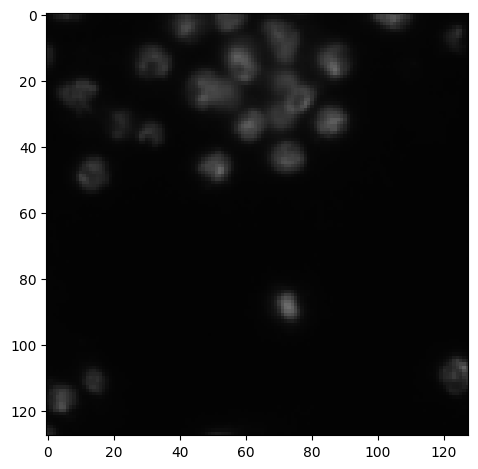

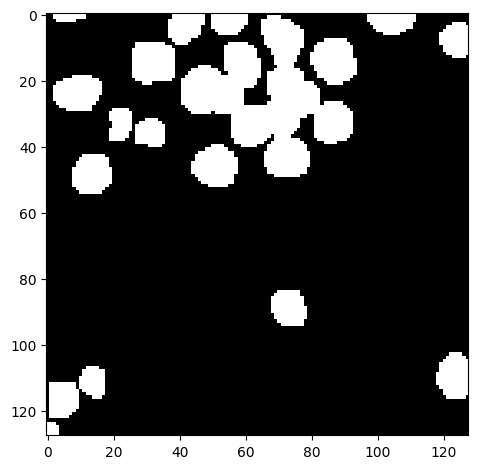

In [51]:
image_x=random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))

plt.show()

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs = output_block(x)

    model = Model(inputs, outputs)
    return model

In [57]:
model = build_model((128, 128, 3))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 16, 16,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv4[0][

 Total params: 29,297,570 (111.76 MB)

 Trainable params: 29,290,274 (111.73 MB)

 Non-trainable params: 7,296 (28.50 KB)

In [58]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [59]:
results=model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=30,callbacks=callbacks)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.8291 - loss: 0.4757 - val_accuracy: 0.9311 - val_loss: 0.3884
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9368 - loss: 0.2624 - val_accuracy: 0.9497 - val_loss: 0.2177
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.9625 - loss: 0.1661 - val_accuracy: 0.9531 - val_loss: 0.1501
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9646 - loss: 0.1330 - val_accuracy: 0.9620 - val_loss: 0.1349
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9616 - loss: 0.1230 - val_accuracy: 0.9602 - val_loss: 0.1244
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9619 - loss: 0.1149 - val_accuracy: 0.9653 - val_loss: 0.1065
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9645 - loss: 0.0994 - val_accuracy: 0.9564 - val_loss: 0.1186
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9665 - loss: 0.0914 - val_accuracy: 0.9570 - v

In [60]:
predict_test=model.predict(X_test,verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


In [61]:
predict_test_t=(predict_test>0.5).astype(np.uint8)

In [62]:
X_test.shape
predict_test_t.shape

(65, 128, 128, 1)

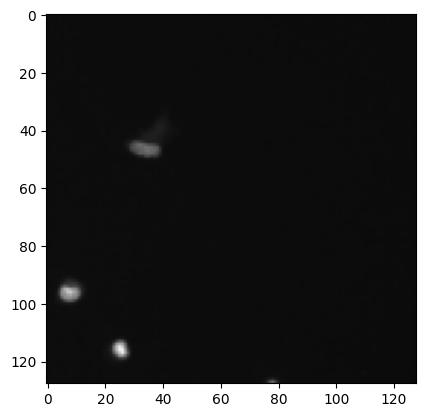

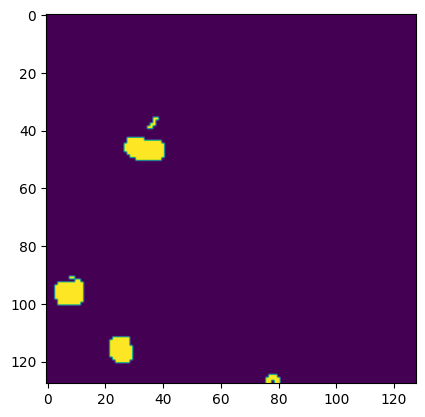

In [64]:
plt.imshow(X_test[4])
plt.show()
plt.imshow(np.mean(predict_test_t[4], axis=2))
plt.show()

In [65]:
import numpy as np
import tensorflow as tf

predict_train = model.predict(X_train,verbose=1)

def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection
    
    if union == 0:
        return 0.0
    else:
        return intersection / union

ious = []
for i in range(len(Y_train)):
    iou = calculate_iou(Y_train[i], predict_train[i])
    ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step
Mean IoU: 0.8781745701553657


In [66]:
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    
    total_cm = np.zeros((2, 2), dtype=np.int64)
    
    for i in range(len(y_true)):
        y_true_flat = y_true[i].flatten()
        y_pred_flat = y_pred[i].flatten()
        
        cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])
        total_cm += cm
    
    return total_cm

conf_matrix = calculate_confusion_matrix(Y_train, predict_train)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[8061034  192550]
 [ 132606 2591090]]
